#**Chapter 4: Implementation.**

Part 1: Logistic Regression (baseline model)

A:
  1. Upload data
  2. EDA
  3. Test Preprocessing & cleanning

B.
  1. Split train/test(validation) dataset
  2. TFIDF Vectorisor & Remove Stopwords

C.
  1. Tuning Hyperparameter
  2. Cross Validation

D.
  1. Test on unseen data
  2. count predicted Label


Part 2: Support Vector Machine





# Part 1: Logistic Regression (baseline model)

## A:
1. Upload Data

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

training_data = pd.read_csv('/content/drive/MyDrive/Dissertation-Coding part/datasets/Train.csv')

#check training data
print(training_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                Text  Label
0  "Vision coverageVacation PayDisability insuran...      1
1  "- 115 EUR per week. We guarantee you: • Work ...      1
2  "language minimum proficiency level: • Diligen...      1
3  "the shift); Overtime is paid up to 125% more....      1
4  "be paid. The city is Munich. Immediate depart...      1


#EDA:

In [2]:
print(training_data.dtypes)
print(training_data.shape)
print(training_data.describe())

Text     object
Label     int64
dtype: object
(2000, 2)
             Label
count  2000.000000
mean      0.500000
std       0.500125
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000


#Missing Value


In [3]:
training_data.isnull()
training_data.isnull().sum()

,0
Text,0
Label,0


  3. Test Preprocessing & cleanning
  - create a function (clean_text)
    1. convert to ASCII
    2. Normalise Text (Lower case)
    3. Tokenised dataset
    4. Remove Punctuations and expand contractions
    
  - apply function to clean both train and test dataset


In [4]:
#install to use module
!pip install contractions

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import unicodedata
import nltk
import string
import contractions

#[1]
nltk.download('punkt')

#Build a text cleaning function
def clean_text(raw_text):
    # Convert UTF characters to a simple ASCII format
    def change_utf(text):
        #[2]
        #[3]
        text = unicodedata.normalize('NFKD', text)
        #to ASCII, ignore none ascii format
        text = text.encode('ascii', 'ignore').decode('ascii')
        return text

    #specify the text will change format to ascii for the next text cleanning step
    UTF_text = change_utf(raw_text)

    #Lower case
    normalised_text = UTF_text.lower()

    #Expand contractions
    normalised_text = contractions.fix(normalised_text)

    # Remove specific symbols (you can expand this list)
    specific_symbols = ['---', '...', '***', '``', '--', '"', "'", "’", "“", "”"]
    for symbol in specific_symbols:
        normalised_text = normalised_text.replace(symbol, '')

    #Tokenization
    words = nltk.word_tokenize(normalised_text)

    #Remove numbers and specific symbols
    words = [word for word in words if not word.isdigit()]

    #Join tokens back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#apply clean_text function to clean training data for model training

In [5]:
training_data = pd.read_csv('/content/drive/MyDrive/Dissertation-Coding part/datasets/Train.csv')

#Apply function(clean_text)
training_data['cleaned_text_train'] = training_data['Text'].apply(clean_text)

#check
print(training_data[['Text', 'cleaned_text_train']].head())


                                                Text  \
0  "Vision coverageVacation PayDisability insuran...   
1  "- 115 EUR per week. We guarantee you: • Work ...   
2  "language minimum proficiency level: • Diligen...   
3  "the shift); Overtime is paid up to 125% more....   
4  "be paid. The city is Munich. Immediate depart...   

                                  cleaned_text_train  
0  vision coveragevacation paydisability insuranc...  
1  - eur per week . we guarantee you : work in a ...  
2  language minimum proficiency level : diligence...  
3  the shift ) ; overtime is paid up to % more . ...  
4  be paid . the city is munich . immediate depar...  


#specify the TWO coulumns to model training (cleaned_text_train & Label)

In [6]:
cleaned_train_data = training_data[['cleaned_text_train', 'Label']]


## B.
  1. Split train/test(validation) dataset
  2. Feature Extraction TFIDF
  3. remove stopwords
  4. Initialise LR model
  5. Parameter tuning with cross validation

#C.
ref: https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0

Tuning Hyperparameter
- C: indicating the strength of regularization, needs to be a positive float. It functions in conjunction with the penalty to balance overfitting.

- penalty:(regularization)is designed to lower the model's generalization error and mitigate overfitting. since we seen training data consistantly give 100%, which may suggest our model have overfitting issue.

- solver: support penalty in this case: determine the optimization method used during model training. Impacts the efficiency, scalability, and sometimes even the effectiveness of the model

In [7]:
from sklearn.model_selection import train_test_split as split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


#[4]
#Split the training data into train/test:
#Week10: theory and application
class Dataset:
    def __init__(self):#A structure to store the features (X) and labels (y) of my dataset
        self.X = None
        self.y = None
        self.V = None#Vectorized features

#specify column
cleaned_train_data.columns = ['cleaned_text_train', 'Label']

#Convert textual columns to strings for TF-IDF vectorization
cleaned_train_data['cleaned_text_train'] = cleaned_train_data['cleaned_text_train'].astype(str)

# Prepare text and labels
X = cleaned_train_data['cleaned_text_train'].values#prepare textual data
y = cleaned_train_data['Label'].values#prepare label(0or1)

# Initialize train and test Dataset objects
train = Dataset()
test = Dataset()

#Splitting the data into training and testing sets(has tried combinations 0.2/0.3/0.4/0.5/0.6/0.7/0.8/0.9= did not change accuracies of training) will keep 0.2 here
train.X, test.X, train.y, test.y = split(X, y, test_size=0.20, random_state=123456789)

<ipython-input-7-7eeb2dadb936>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_train_data['cleaned_text_train'] = cleaned_train_data['cleaned_text_train'].astype(str)


In [8]:
#Show all the parameter
#week8: theory and application
from sklearn.linear_model import LogisticRegression

estimators = {
    'Logistic Regression' : LogisticRegression()
}

for name, classifier in estimators.items():
    print(f'{name} hyper-parameters\n')
    params = classifier.get_params()
    for param, default in params.items():
        print(f'... {param:25s}: {default}')
    print()


Logistic Regression hyper-parameters

... C                        : 1.0
... class_weight             : None
... dual                     : False
... fit_intercept            : True
... intercept_scaling        : 1
... l1_ratio                 : None
... max_iter                 : 100
... multi_class              : auto
... n_jobs                   : None
... penalty                  : l2
... random_state             : None
... solver                   : lbfgs
... tol                      : 0.0001
... verbose                  : 0
... warm_start               : False



#Remove stop words&TFIDF  (here i specify> stop_words='english')
vectorizer_no_sw = TfidfVectorizer(stop_words='english')

#Vectorize the textual data(both train/test)
X_train_vec_no_sw = vectorizer_no_sw.fit_transform(train.X)
X_test_vec_no_sw = vectorizer_no_sw.transform(test.X)

#Initialise LR model specify no stopwords
LR_model_no_sw = LogisticRegression()

#Define the parameters to search and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
}

#The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.
#GridSearch to tune hyperparameter: ref:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search_LR = GridSearchCV(estimator=LR_model_no_sw, param_grid=param_grid, cv=5)#default 5 fold

#Fit the model on prepared training data
grid_search_LR.fit(X_train_vec_no_sw, train.y)

# Result: Best Parameters
print("Best Parameters:", grid_search_LR.best_params_)

#Debugging, orginal tuning gives error:
- gives me Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
- FitFailedWarning:
**30 fits failed out of a total of 120.**
*because L1 does not suppoty lbfgs only supprot l2. (so change this)

In [9]:
#Remove stop words&TFIDF  (here i specify> stop_words='english')
vectorizer_no_sw = TfidfVectorizer(stop_words='english')

#Vectorize the textual data(both train/test)
X_train_vec_no_sw = vectorizer_no_sw.fit_transform(train.X)
X_test_vec_no_sw = vectorizer_no_sw.transform(test.X)

#Initialise LR model specify no stopwords
LR_model_no_sw = LogisticRegression()

#Define the parameters to search and their possible values: fix the combination issues (L1&lbfgs)
param_grid = [
    {'penalty': ['l1'], 'C' : [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear']},
    {'penalty': ['l2'], 'C' : [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
]

#The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.
#GridSearch to tune hyperparameter: [5]
grid_search_best_LR = GridSearchCV(estimator=LR_model_no_sw, param_grid=param_grid, cv=5)#default 5 fold

#Fit the model on prepared training data
grid_search_best_LR.fit(X_train_vec_no_sw, train.y)

#Best Parameters
print("Best Parameters:", grid_search_best_LR.best_params_)


Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


Now it gives :
- Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
- Fit the tuned model on test data
- 100% accuracy, will remove 100 in parameter C)

2. Now the Best Parameters is {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [10]:
#use best_estimator to use the tuned model: Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
#.predict on test data(from the split) to see performance
#[6]
y_test = grid_search_best_LR.best_estimator_.predict(X_test_vec_no_sw)

#see the test accuracy:
#[8]
test_accuracy = accuracy_score(test.y, y_test)
print(f"Test Accuracy: {test_accuracy}")

#classification report
#[7]
print("Classification Report>")
print(classification_report(test.y, y_test))


Test Accuracy: 1.0
Classification Report>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       194
           1       1.00      1.00      1.00       206

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



# Visualise ROC curve for interpretation;
ref: https://www.kaggle.com/code/nirajvermafcb/comparing-various-ml-models-roc-curve-comparison

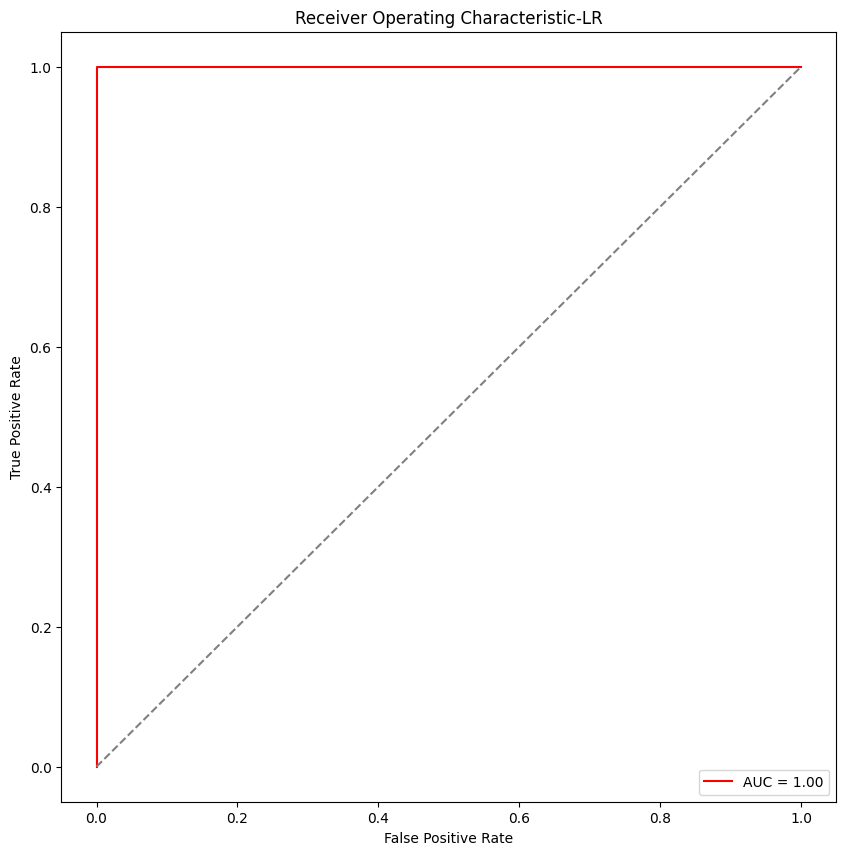

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
#[9]
#Vectorize the textual data(both train/test)
X_train_vec_no_sw = vectorizer_no_sw.fit_transform(train.X)
X_test_vec_no_sw = vectorizer_no_sw.transform(test.X)

#Predict probabilities on the test data using the best tuned model
y_prob = grid_search_best_LR.predict_proba(X_test_vec_no_sw )[:, 1]  # This will give you positive class prediction probabilities

#threshold the probabilities to get class predictions
y_pred = np.where(y_prob > 0.5, 1, 0)

#Evaluate the model
accuracy = grid_search_best_LR.score(X_test_vec_no_sw , test.y)
accuracy

# Confusion Matrix
test_confusion_matrix = confusion_matrix(test.y, y_pred)
test_confusion_matrix

#AUC-ROC score
auc_roc = roc_auc_score(test.y, y_prob)
auc_roc

#ROC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(test.y, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

#Plot ROC Curve
plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic-LR')
plt.plot(false_positive_rate, true_positive_rate, color='red', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Still 100 percent accuracy
- test best LR model on unseen/ unlabelled data
ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

In [12]:
#[10]
#load testing(unseen/unlabelled) data
unseen_test_data = '/content/drive/MyDrive/Dissertation-Coding part/datasets/Testing data (unseen:unlabelled).csv'
unseen_test_data = pd.read_csv(unseen_test_data)

#apply text preprocessing function defined before:(clean_text)
unseen_test_data['cleaned_text_unseen_test'] = unseen_test_data['Text'].apply(clean_text)

#convert to str for tfidf to read
unseen_test_data['cleaned_text_unseen_test'] = unseen_test_data['cleaned_text_unseen_test'].astype(str)

X_unseen_test_vec = vectorizer_no_sw.transform(unseen_test_data['cleaned_text_unseen_test'])


#Best tuned LR Model for Prediction
final_unseen_test_predictions = grid_search_best_LR.best_estimator_.predict(X_unseen_test_vec)


#generate the predicted label
unseen_test_data['Predicted_Label'] = final_unseen_test_predictions

unseen_test_data[['Text', 'Predicted_Label']].head()

unseen_test_data.to_csv('/content/drive/MyDrive/Dissertation-Coding part/datasets/predictions_on_unseen_test.csv', index=False)




In [13]:
#count labels of the predicted label
countlabel= pd.read_csv('/content/drive/MyDrive/Dissertation-Coding part/datasets/predictions_on_unseen_test.csv')

#use: value_counts() function
#[15]
label_counts = countlabel['Predicted_Label'].value_counts()

print(label_counts)

Predicted_Label
1    1200
0    1200
Name: count, dtype: int64


#PCA:Vector Visualisation
ref: https://medium.com/@GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


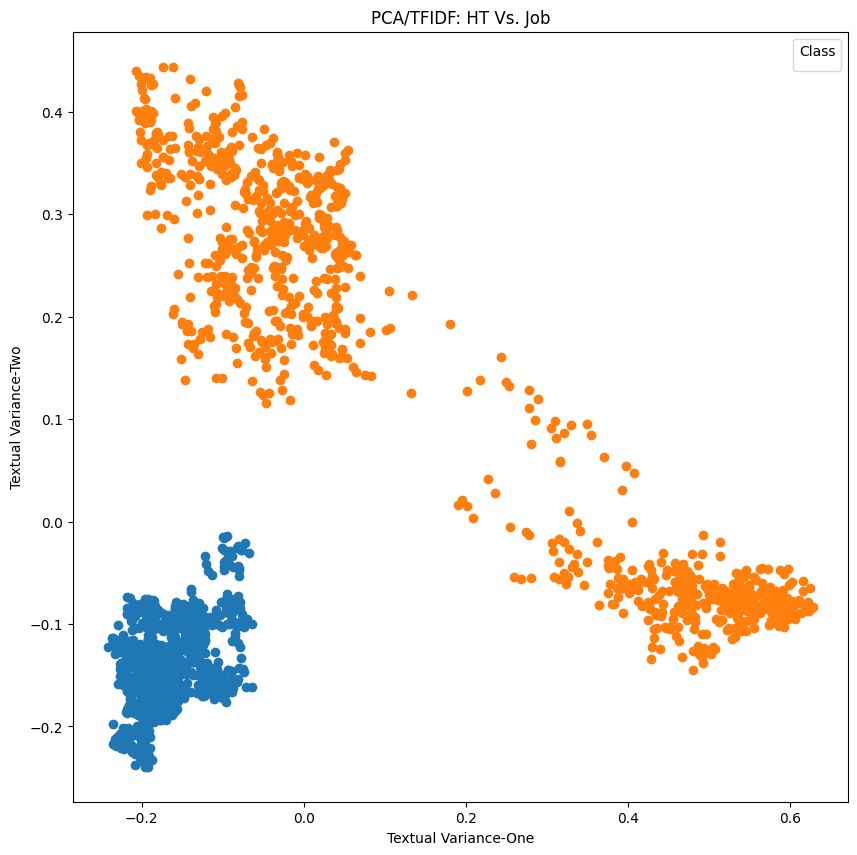

In [14]:
#[11]
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Load Data
data_file_path = '/content/drive/MyDrive/Dissertation-Coding part/datasets/Train.csv'
text_df = pd.read_csv(data_file_path, encoding="ISO-8859-1", engine='python')

#Apply the preprocessing function defined before (clean_text)
text_df['cleaned_text'] = text_df['Text'].apply(clean_text)

#Convert to string  for TF-IDF to read
text_df['cleaned_text'] = text_df['cleaned_text'].astype(str)

#tfidf model
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)

# Fit Model and Transform the textual data
tfidf_vectors = tfidf_model.fit_transform(text_df['cleaned_text']).toarray()

#Set PCA to 2D
pca = PCA(n_components=2)

#Apply PCA to the TF-IDF vectors
tfidf_pca_result = pca.fit_transform(tfidf_vectors)

#New D2 Dataframe (PCA)
df2d = pd.DataFrame(tfidf_pca_result, columns=['x', 'y'])
df2d['Label'] = text_df['Label']

#Plot Data Visualization
plt.figure(figsize=(10, 10))
for label, subplot in df2d.groupby('Label'): #ref: https://stackoverflow.com/questions/13872533/how-to-plot-different-groups-of-data-from-a-dataframe-into-a-single-figure
        plt.scatter(subplot['x'], subplot['y'])

plt.title('PCA/TFIDF: HT Vs. Job')
plt.xlabel('Textual Variance-One')
plt.ylabel('Textual Variance-Two')
plt.legend(title='Class')
plt.show()




#topic identification with TFIDF

ref: https://www.datacamp.com/datalab/templates/recipe-python-topic-identification-tfidf

In [15]:
!pip install wordcloud


In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import os
#[12]

HT_path = '/content/drive/MyDrive/Dissertation-Coding part/datasets/Cleaned/HT_test_merged.csv'

HT_train = pd.read_csv(HT_path, encoding="ISO-8859-1", engine='python')

HT_train['cleaned_text'] = HT_train['text'].apply(clean_text)

HT_train['cleaned_text'] = HT_train['cleaned_text'].astype(str)

# Create reference dictionary and corpus
#.index- [13]
#debugging- convert numby array to list; [14]
reference = dict(zip(HT_train.index, HT_train['cleaned_text']))
corpus = HT_train['cleaned_text'].tolist()

#Create a Tfidf matrix
HT_tfidf_model = TfidfVectorizer(stop_words='english',
                                 ngram_range=(1,1),
                                 max_df=0.6,
                                 min_df=0.01)

X_tfidf = HT_tfidf_model.fit_transform(corpus)
feature_names = HT_tfidf_model.get_feature_names_out()

dense = X_tfidf.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

#Find the top words in each document
top_dict = {}
data = df.transpose()
data.columns = reference.keys()

for i, c in enumerate(data.columns):
    top = data.loc[:, c].sort_values(ascending=False).head(30)
    top_dict[data.columns[i]] = list(zip(top.index, top.values))

#Print the top 15 words for each entry
for entry, top_words in top_dict.items():
    print(entry)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

0
plasterboard, panels, accommodation, taxes, site, profiles, glued, perform, installed, assigned, main, function, 200, recruited
---
1
warehouses, amazon, sainsburys, clothes, whistl, offices, tulip, ibis, agency, couriers, parcel, tesco, toys, moy
---
2
trouble, costs, help, chance, contact, threatening, current, situation, causing, opportunity, development, way, going, transport
---
3
costs, contact, wanted, trouble, help, going, transport, possible, feel, wealthy, obligated, com, mullerdieter641, gmail
---
4
payment, hourly, parcels, sainsburys, picker, a12, february, travel, organize, good, conditions, departures, average, order
---
5
employees, accommodation, recommended, various, rent, germany, shopping, center, recruited, double, kitzingen, having, bad, habits
---
6
fish, processing, fresh, factory, especially, farming, knife, operations, built, filleting, contract, qualified, trained, sea
---
7
utrecht, zoetermeer, age, needed, deducted, live, 10, 45, online, sizes, pack, 30, 

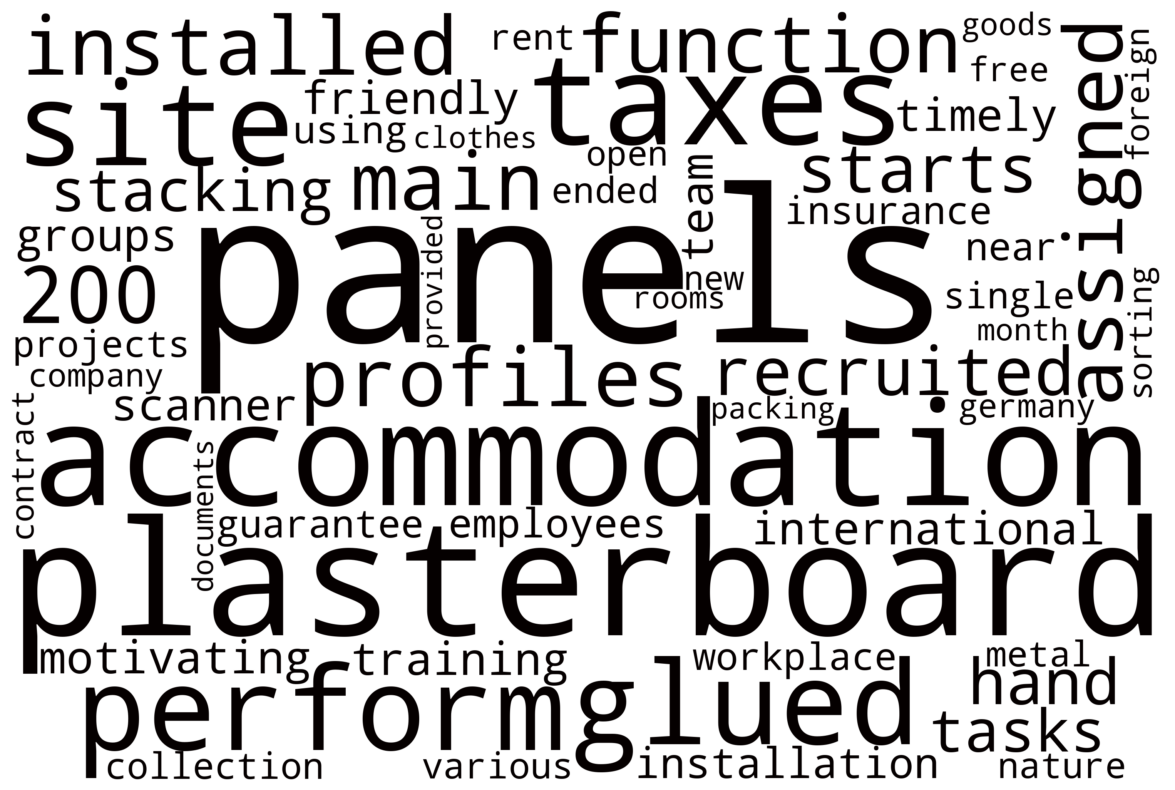

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#change the word color to black
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

# Specify the document you want to create the WordCloud for
document_column = data.columns[0]  # Replace 0 with the index of the desired document column

wc = WordCloud(background_color="white",              #select background color
               width=3000,                            #set width
               height=2000,                           #set height
               max_words=500)                         #set max amount of words

wc.generate_from_frequencies(data[document_column])   #choose column for wordcloud
wc.recolor(color_func=black_color_func)               #set the word color to black

plt.figure(figsize=[15,10])                           #set the figsize
plt.imshow(wc, interpolation="bilinear")              #plot the WordCloud
plt.axis("off")                                       #remove plot axes
plt.savefig('wordcloud-HT.png')         #save the WordCloud with the document nameplt.show()                                            # display the plot


In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import os

HT_path = '/content/drive/MyDrive/Dissertation-Coding part/datasets/Cleaned/Job_train_merged.csv'

Job_train = pd.read_csv(HT_path, encoding="ISO-8859-1", engine='python')

Job_train['cleaned_text'] = Job_train['text'].apply(clean_text)

Job_train['cleaned_text'] = Job_train['cleaned_text'].astype(str)

# Create reference dictionary and corpus
#.index- [13]
#debugging- convert numby array to list; [14].
reference = dict(zip(Job_train.index, Job_train['cleaned_text']))
corpus = Job_train['cleaned_text'].tolist()

#Create a Tfidf matrix
Job_tfidf_model = TfidfVectorizer(stop_words='english',
                                 ngram_range=(1,1),
                                 max_df=0.6,
                                 min_df=0.01)

X_tfidf = Job_tfidf_model.fit_transform(corpus)
feature_names = Job_tfidf_model.get_feature_names_out()

dense = X_tfidf.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

#Find the top words in each document
top_dict = {}
data = df.transpose()
data.columns = reference.keys()

for i, c in enumerate(data.columns):
    top = data.loc[:, c].sort_values(ascending=False).head(30)
    top_dict[data.columns[i]] = list(zip(top.index, top.values))

#Print the top 15 words for each entry
for entry, top_words in top_dict.items():
    print(entry)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

0
committed, education, boxes, potential, calls, kg, lbs, raiser, fellow, informational, teaching, weighing, 13, senior
---
1
early, careers, role, ukas, professional, organized, companies, delighted, increasing, maximum, studying, combined, discretion, 30
---
2
brand, plans, value, user, program, everyday, interactions, representing, region, premium, traits, image, enhancement, lifetime
---
3
early, careers, role, working, ukas, professional, organized, companies, delighted, increasing, maximum, 30, professionalism, stages
---
4
store, customers, delicious, memories, shop, meal, adventurous, save, remain, id, tidy, photographic, mental, physical
---
5
ownership, project, home, highly, customer, working, self, improvements, dots, big, innovative, asee, crisis, picturea
---
6
provider, residential, sales, healthcare, clinical, adaptable, reasoning, bacheloras, specialist, inhouse, field, passed, peopleas, lives
---
7
brand, local, visible, available, outlet, everyday, interactions, proo

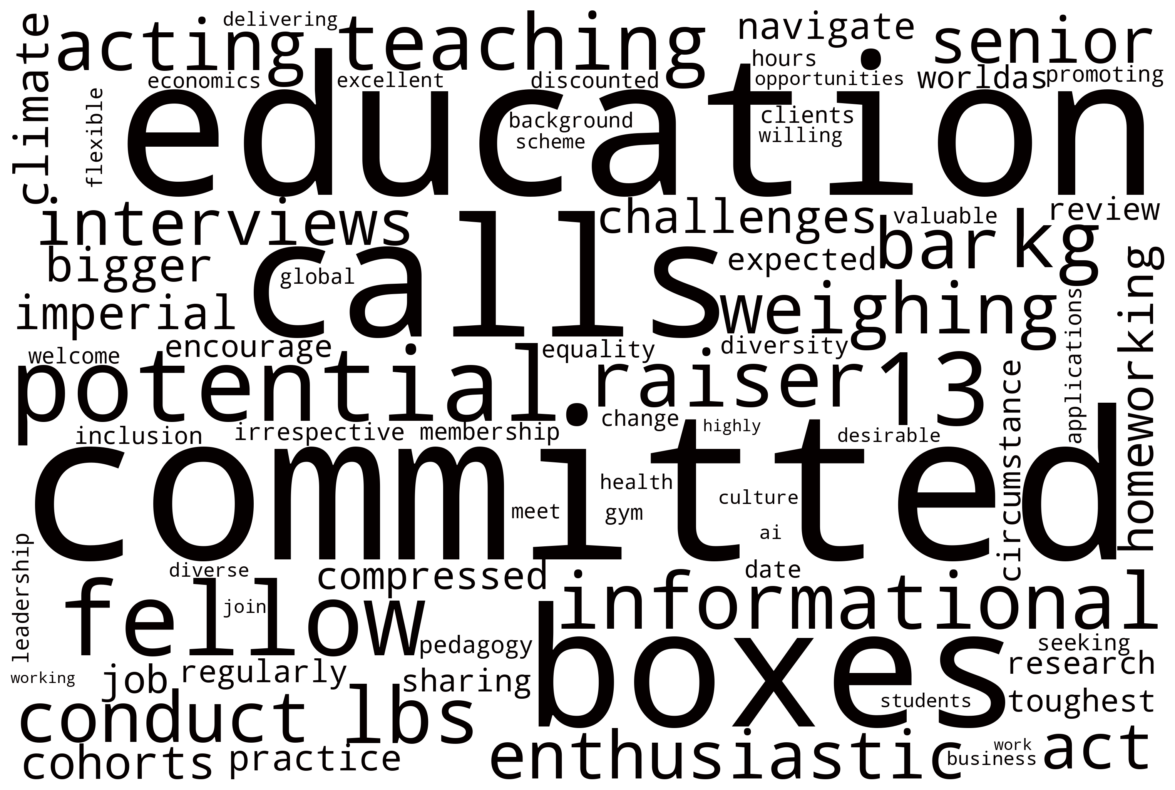

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Function to change the word color to black
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

# Specify the document you want to create the WordCloud for
document_column = data.columns[0]  # Replace 0 with the index of the desired document column

wc = WordCloud(background_color="white",              #select background color
               width=3000,                            #set width
               height=2000,                           #set height
               max_words=500)                         #set max amount of words

wc.generate_from_frequencies(data[document_column])   #choose column for wordcloud
wc.recolor(color_func=black_color_func)               #set the word color to black

plt.figure(figsize=[15,10])                           #set the figsize
plt.imshow(wc, interpolation="bilinear")              #plot the WordCloud
plt.axis("off")                                       #remove plot axes
plt.savefig('wordcloud-job.png')         #save the WordCloud with the document nameplt.show()                                            # display the plot

# Text real-word data:

In [21]:
import pandas as pd
#[10]
#load testing(unseen/unlabelled) data
unseen_test_data_path = '/content/drive/MyDrive/Dissertation-Coding part/datasets/Text2 (unseen).csv'
unseen_test_data = pd.read_csv(unseen_test_data_path)

#apply text preprocessing function defined before:(clean_text)
unseen_test_data['cleaned_text_unseen_test'] = unseen_test_data['Text2'].apply(clean_text)

#convert to str for tfidf to read
unseen_test_data['cleaned_text_unseen_test'] = unseen_test_data['cleaned_text_unseen_test'].astype(str)

X_unseen_test_vec = vectorizer_no_sw.transform(unseen_test_data['cleaned_text_unseen_test'])

#Best tuned SVM Model for Prediction
final_unseen_test_predictions = grid_search_best_LR.predict(X_unseen_test_vec)

#generate the predicted label
unseen_test_data['Predicted_Label'] = final_unseen_test_predictions
print(unseen_test_data[['Text2', 'Predicted_Label']].head())

unseen_test_data.to_csv('/content/drive/MyDrive/Dissertation-Coding part/datasets/predictions_on_unseen_tes2t_LR.csv', index=False)


                                               Text2  Predicted_Label
0  Nature of work\nWorkers wanted in Dutch wareho...                1
1  Nature of work\nWorking hours: three shifts: m...                1
2  Nature of work\nWe are looking for workers for...                1
3  Nature of work\nWe are looking for workers for...                1
4  Nature of work\nWe offer a job in Holland, in ...                1


Reference:
1. https://stackoverflow.com/questions/37101114/what-to-download-in-order-to-make-nltk-tokenize-word-tokenize-work
2. https://stackoverflow.com/questions/37101114/what-to-download-in-order-to-make-nltk-tokenize-word-tokenize-work
3. https://towardsdatascience.com/difference-between-nfd-nfc-nfkd-and-nfkc-explained-with-python-code-e2631f96ae6c
4. https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0
5. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
8. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
9. https://www.kaggle.com/code/nirajvermafcb/comparing-various-ml-models-roc-curve-comparison
10. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
11. https://medium.com/@GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d
12. https://www.datacamp.com/datalab/templates/recipe-python-topic-identification-tfidf
13. https://www.w3schools.com/python/ref_list_index.asp
14. https://www.programiz.com/python-programming/numpy/methods/tolist#:~:text=The%20tolist()%20method%20converts,changing%20its%20data%20or%20dimensions
15. https://www.w3resource.com/pandas/series/series-value_counts.php